# TISSUE prediction interval and calibration quality

This notebook contains code for generating most of the figure panels corresponding to Figure 2 of the manuscript. In particular, this notebook contains code for evaluating the TISSUE calibration quality using calibration curves, correlation with prediction errors, and visualizations of these errors and prediction intervals.

It relies on the outputs of `spatial_conformal_uncertainty.py` followed by `get_calibration.py` applied to all eleven benchmark dataset pairs. In particular, it requires running the Python commands in all the job scripts of form: `run_conformal_{i}.slurm`. The h5ad anndata objects and pickle objects should be saved into "scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/" with respect to the current working directory (or an alternative path for stratified grouping results).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
from scipy.stats import pearsonr, spearmanr
import anndata as ad
import seaborn as sns
import pickle
import os

from TISSUE.tissue.experiments import measure_calibration_error
from TISSUE.tissue.utils import large_load

In [2]:
#### Swap dataset names to real identifiers
dataset_mapper = {"Dataset3": "Mouse Hipp.\n(seqFISH)",
                  "Dataset9": "Mouse VISP\n(MERFISH)",
                  "Dataset11": "Mouse PC\n(STARmap)", 
                  "Dataset12": "Human MTG\n(ISS)",
                  "Dataset13": "Mouse VISP\n(ISS)",
                  "Dataset14": "Drosophila Embryo\n(FISH)",
                  "Dataset15": "Mouse SC\n(osmFISH)",
                  "Dataset17": "Mouse VISP\n(ExSeq)",
                  "Axolotl": "Axolotl Brain\n(Stereo-seq)",
                  "Dataset7": "Human U2OS\n(MERFISH)",
                  "Dataset1": "Mouse Gast.\n(seqFISH)"}

method_mapper = {"tangram": "Tangram",
                 "spage": "SpaGE",
                 "knn": "Harmony",
                 "gimvi": "gimVI"}
####

## Calibration curves to evaluate quality of TISSUE prediction intervals

The following code makes plots of the calibration curves (i.e. the fraction of predictions that empirically fall within a specified TISSUE coverage level). Lines that are close to the diagonal (i.e. x=y) indicate good calibration and this quantified using the calibration error annotated on the graph.

### Main setup

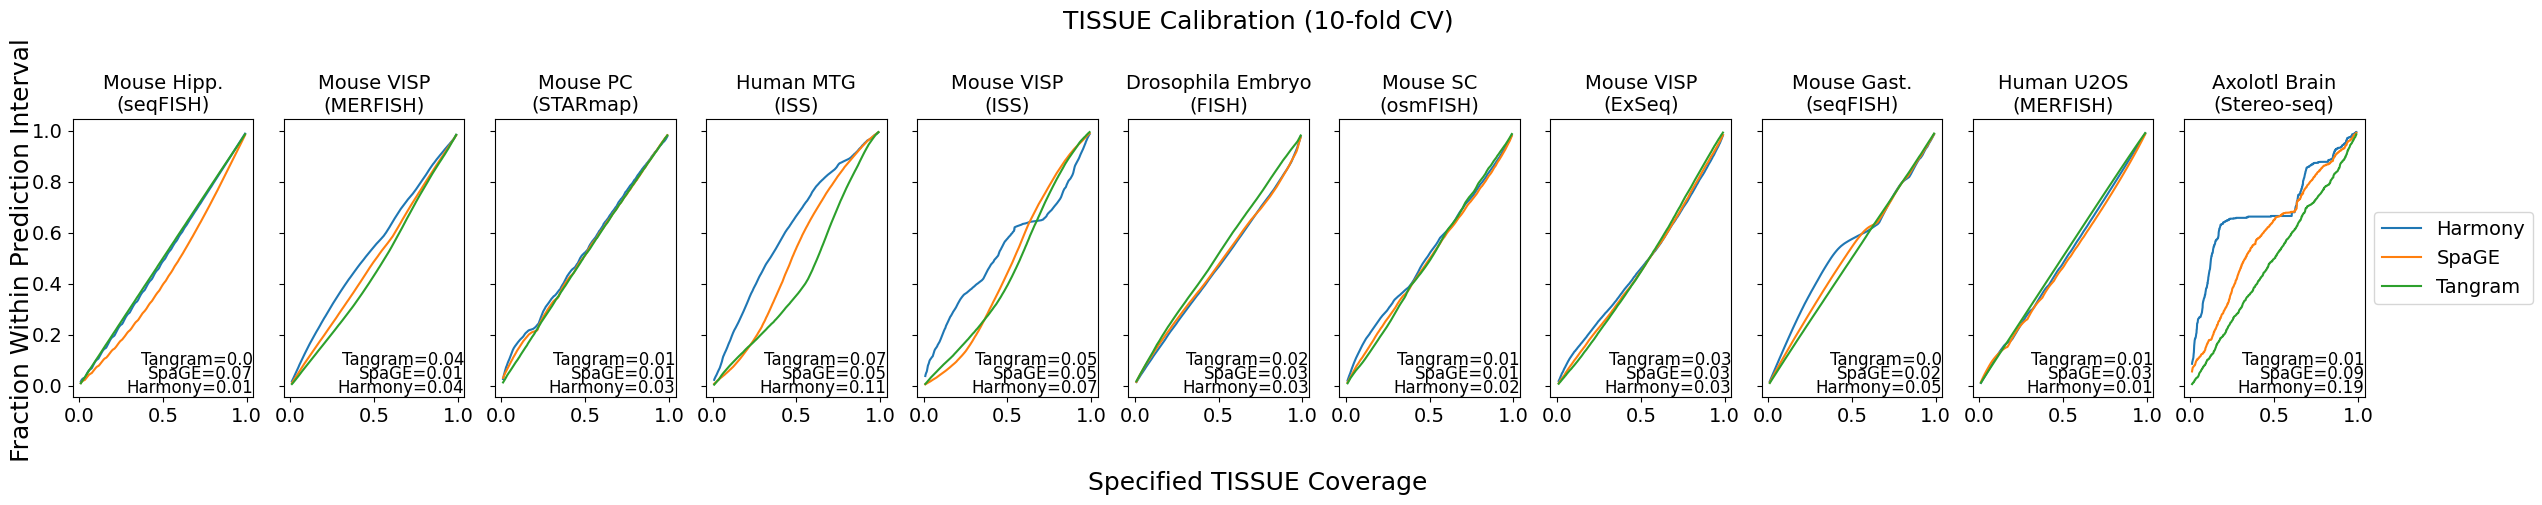

In [3]:
# all in one AVG calibration plot
dataset_names = ["Dataset3", "Dataset9", "Dataset11", "Dataset12", "Dataset13", "Dataset14", "Dataset15", "Dataset17", "Dataset1", "Dataset7", "Axolotl"]
colors = ["tab:blue", "tab:orange", "tab:green"]

fig, axs = plt.subplots(nrows=1, ncols=len(dataset_names), sharex=True, sharey=True, figsize=(26, 5))
for i, dataset_name in enumerate(dataset_names):
    
    # load in pickle object with dictionary of calibration results
    pickleFile = open("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+dataset_name+"_conformal_dict.pkl", 'rb')
    res_dict = pickle.load(pickleFile)
    
    # plot calibration curve from dict results + compute calibration error
    for ki, key in enumerate(res_dict.keys()):
        axs[i].plot(res_dict[key]['1-alpha'], res_dict[key]['test'], linewidth=1.5, label=method_mapper[key], color=colors[ki])
        error = round(measure_calibration_error(res_dict, key),2)
        axs[i].annotate(method_mapper[key]+"="+str(error), xy=(1, 0+(ki*0.05)), xycoords='axes fraction', fontsize=12, horizontalalignment='right', verticalalignment='bottom')
    
    axs[i].set_title(dataset_mapper[dataset_name], fontsize=14)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].tick_params(axis='both', which='minor', labelsize=14)
    
fig.suptitle("TISSUE Calibration (10-fold CV)", fontsize=18)
fig.supxlabel("Specified TISSUE Coverage", fontsize=18)
fig.supylabel("Fraction Within Prediction Interval", fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, ncol=1)
plt.tight_layout(pad=1.8)
plt.savefig('plots/scpi_calibration/REVISED_paneled_AVG_calibration_curves.pdf')
plt.show()

### With automated stratified grouping

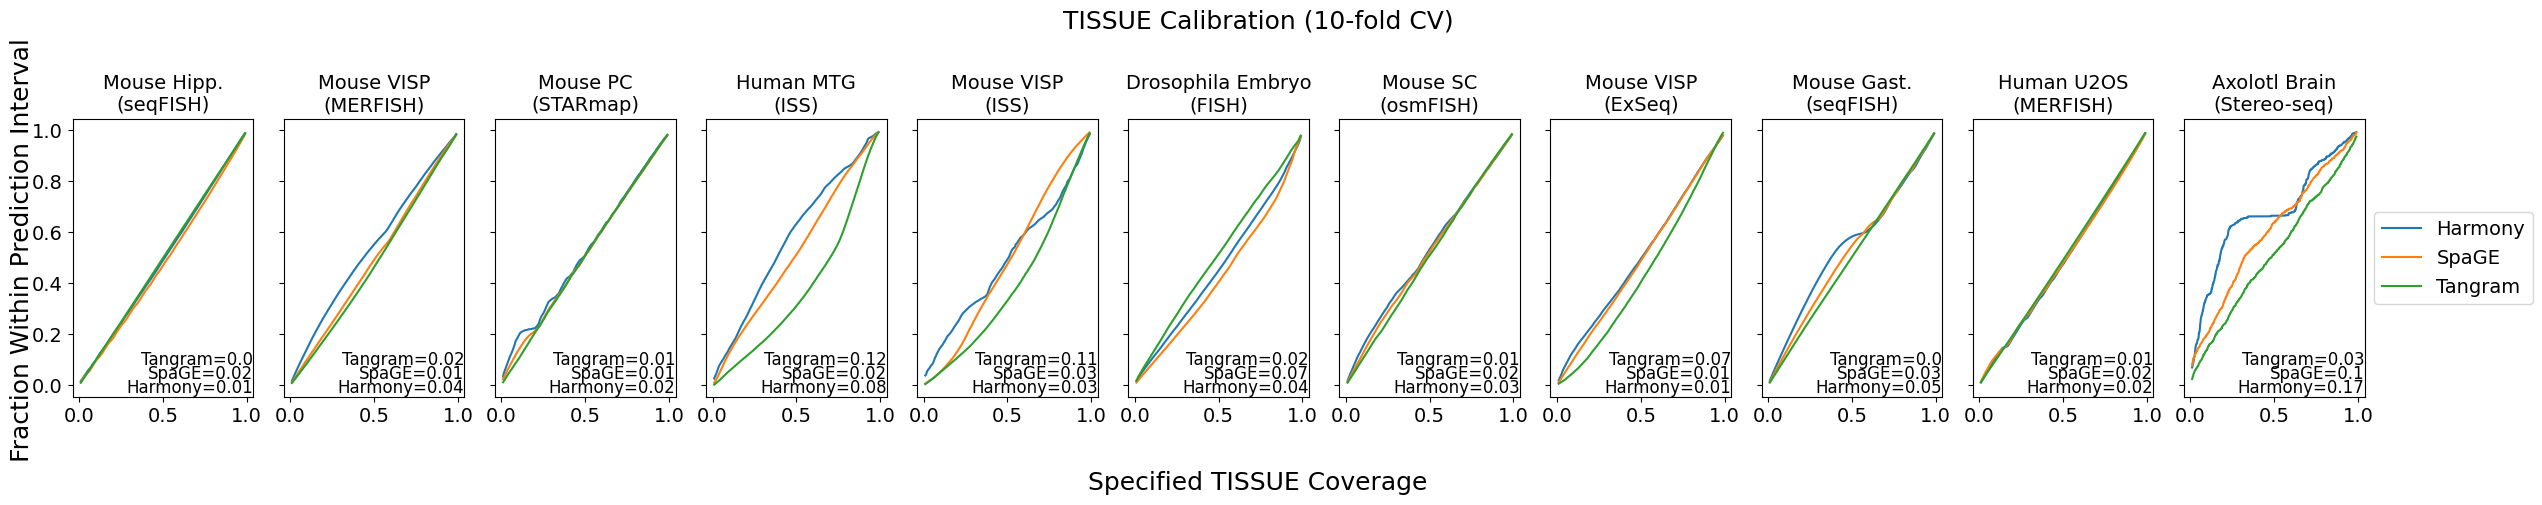

In [4]:
# all in one AVG calibration plot
dataset_names = ["Dataset3", "Dataset9", "Dataset11", "Dataset12", "Dataset13", "Dataset14", "Dataset15", "Dataset17", "Dataset1", "Dataset7", "Axolotl"]

fig, axs = plt.subplots(nrows=1, ncols=len(dataset_names), sharex=True, sharey=True, figsize=(26, 5))
for i, dataset_name in enumerate(dataset_names):
    
    # load in pickle object with dictionary of calibration results
    pickleFile = open("scg_results/scpi/2023Aug1_kautokauto_SDbasedCCPplus1/"+dataset_name+"_conformal_dict.pkl", 'rb')
    res_dict = pickle.load(pickleFile)
    
    # plot calibration curve from dict results + compute calibration error
    for ki, key in enumerate(res_dict.keys()):
        axs[i].plot(res_dict[key]['1-alpha'], res_dict[key]['test'], linewidth=1.5, label=method_mapper[key])
        error = round(measure_calibration_error(res_dict, key),2)
        axs[i].annotate(method_mapper[key]+"="+str(error), xy=(1, 0+(ki*0.05)), xycoords='axes fraction', fontsize=12, horizontalalignment='right', verticalalignment='bottom')
        
    axs[i].set_title(dataset_mapper[dataset_name], fontsize=14)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].tick_params(axis='both', which='minor', labelsize=14)
    
fig.suptitle("TISSUE Calibration (10-fold CV)", fontsize=18)
fig.supxlabel("Specified TISSUE Coverage", fontsize=18)
fig.supylabel("Fraction Within Prediction Interval", fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, ncol=1)
plt.tight_layout(pad=1.8)
plt.savefig('plots/scpi_calibration/REVISED_paneled_AVG_calibration_curves_kautokauto.pdf')
plt.show()

### With each gene shown independently

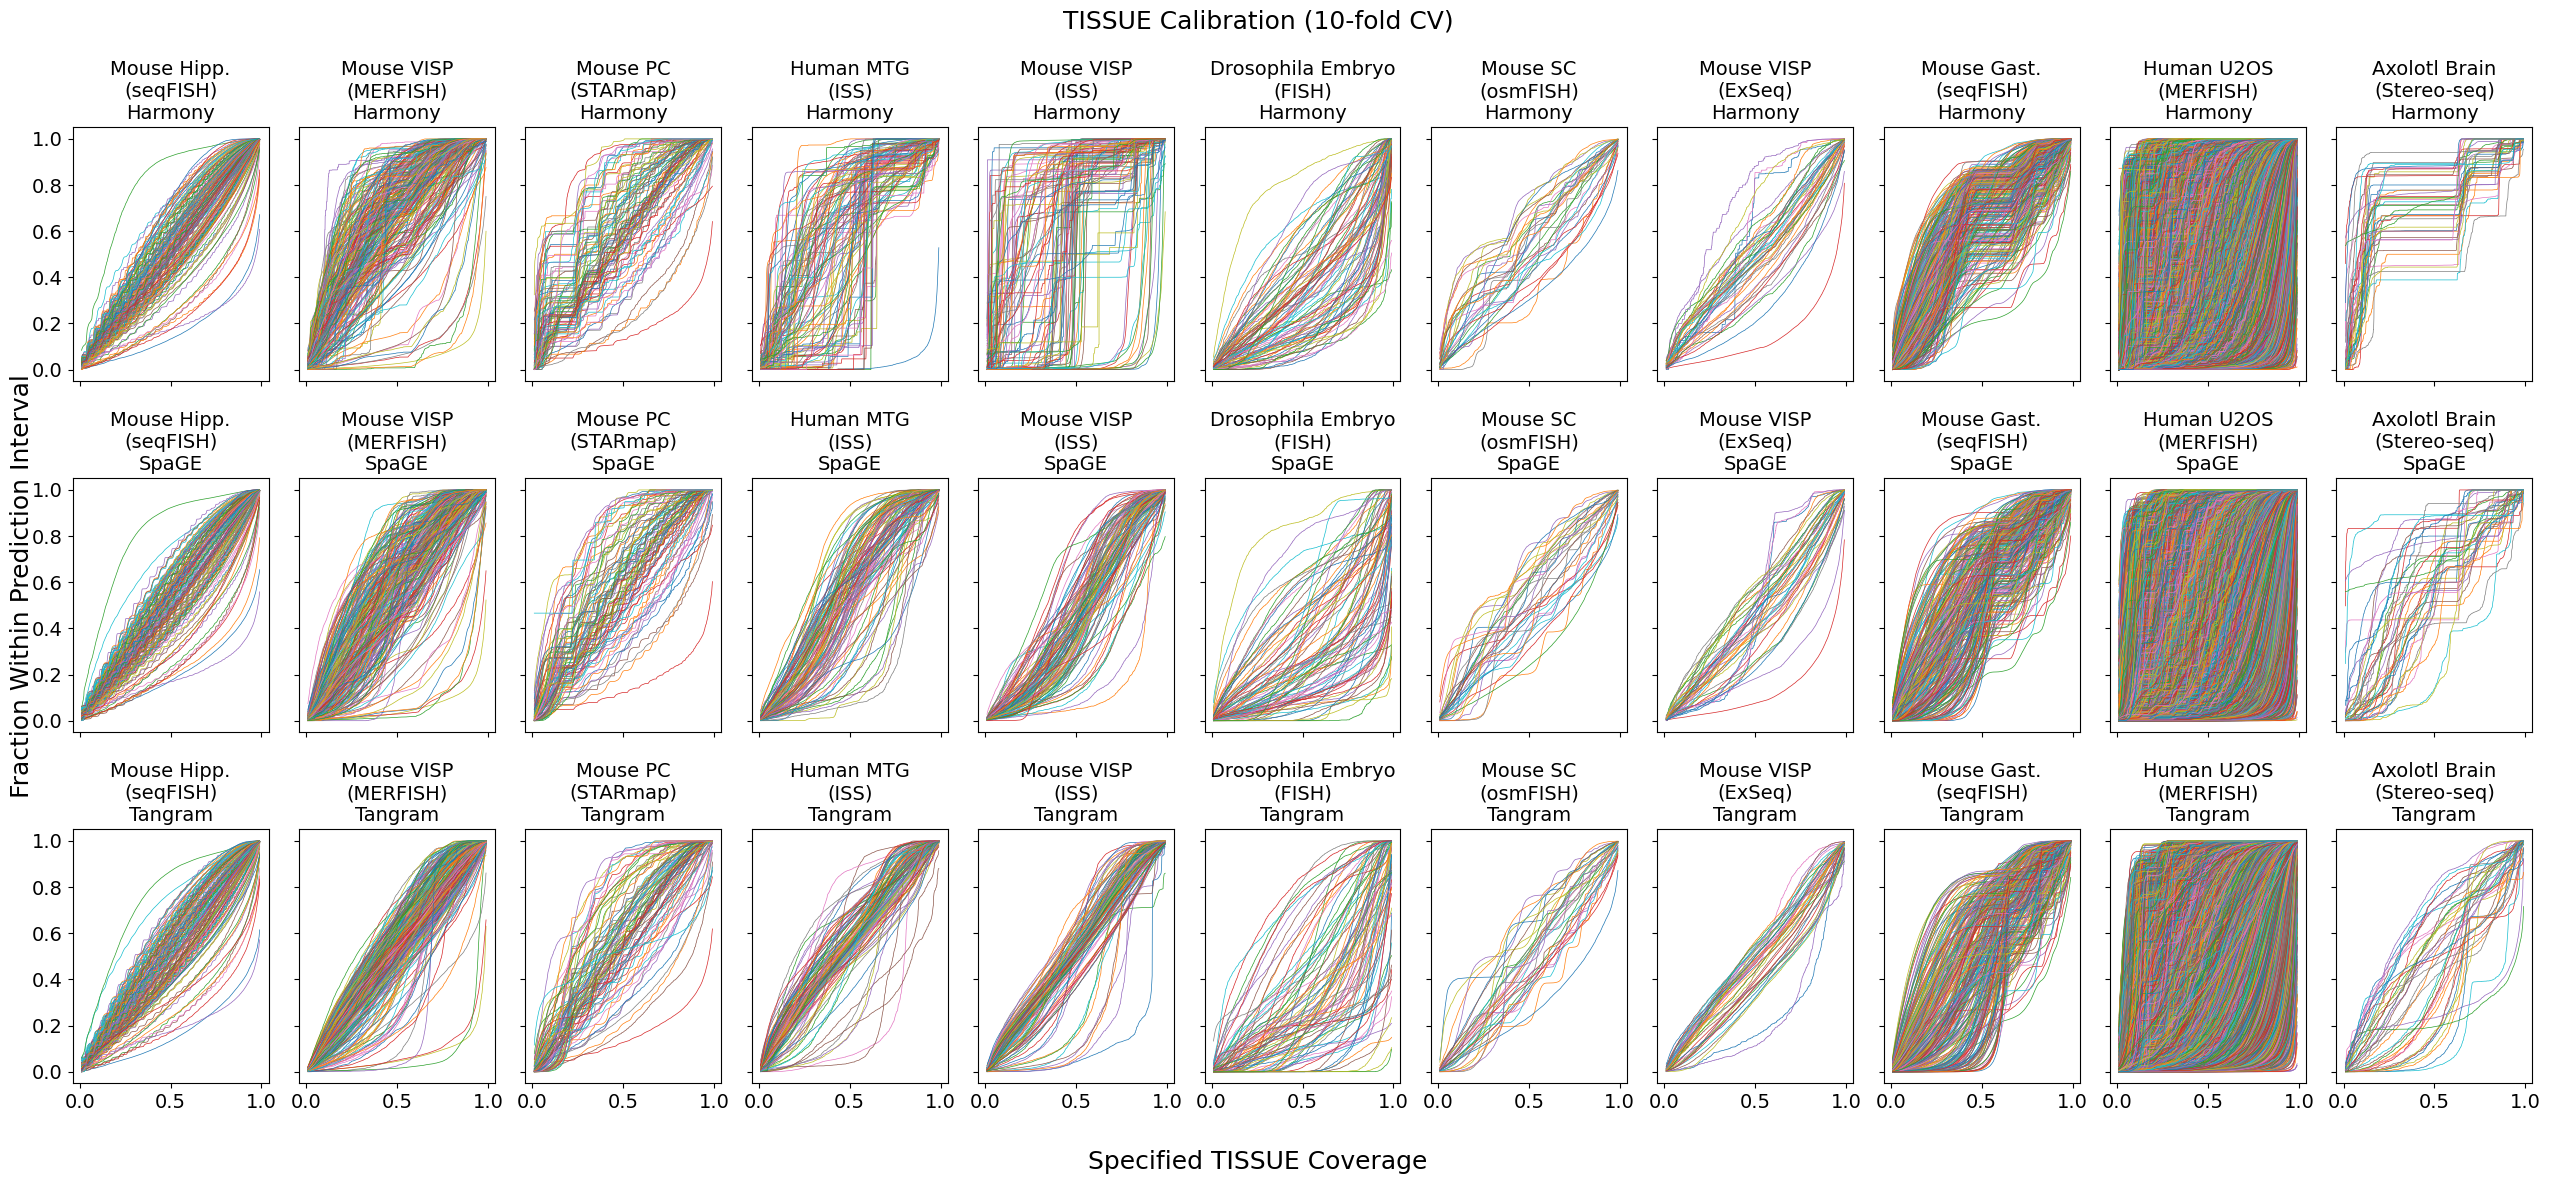

In [5]:
# all in one AVG calibration plot
dataset_names = ["Dataset3", "Dataset9", "Dataset11", "Dataset12", "Dataset13", "Dataset14", "Dataset15", "Dataset17", "Dataset1", "Dataset7", "Axolotl"]
methods = ['knn', 'spage', 'tangram']

fig, axs = plt.subplots(nrows=len(methods), ncols=len(dataset_names), sharex=True, sharey=True, figsize=(26, 12))
for i, dataset_name in enumerate(dataset_names):
    
    # load in pickle object with dictionary of calibration results
    pickleFile = open("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+dataset_name+"_conformal_dict.pkl", 'rb')
    res_dict = pickle.load(pickleFile)

    # plot calibration curve from dict results + compute calibration error
    for j, m in enumerate(methods):
        for gene in res_dict[m]['ind_gene_results'].keys():
            axs[j,i].plot(res_dict[m]['ind_gene_results'][gene]['1-alpha'],
                     res_dict[m]['ind_gene_results'][gene]['test'],
                     linewidth=0.5, rasterized=True)
    
        axs[j,i].set_title(f"{dataset_mapper[dataset_name]}\n{method_mapper[m]}", fontsize=14)
        axs[j,i].tick_params(axis='both', which='major', labelsize=14)
        axs[j,i].tick_params(axis='both', which='minor', labelsize=14)
    
fig.suptitle("TISSUE Calibration (10-fold CV)", fontsize=18)
fig.supxlabel("Specified TISSUE Coverage", fontsize=18)
fig.supylabel("Fraction Within Prediction Interval", fontsize=18)
plt.tight_layout(pad=1.8)
plt.savefig('plots/scpi_calibration/REVISED_paneled_INDGENE_calibration_curves.pdf', dpi=300)
plt.show()

## Representative spatial visualizations of prediction intervals and prediction errors

Several plots showing prediction error and the TISSUE prediction interval width for some representative genes and datasets.

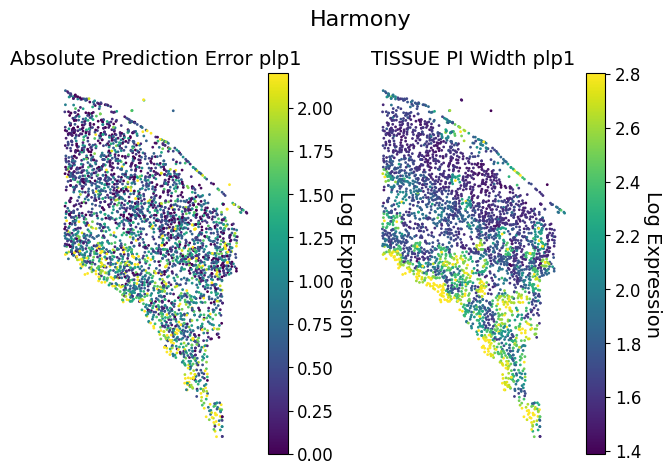

In [5]:
# knn -- plp1 - Dataset15
adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/Dataset15_knn_spage_tangram_SCPI.h5ad")
best_gene = "plp1"
m = 'knn'
pi_width = 67


################
i = np.where(adata.var_names == best_gene)[0]

# define consistent color map
all_vals = np.concatenate((np.abs(adata.X[:,i].flatten()-adata.obsm[m+"_predicted_expression"][best_gene].values),
                           adata.obsm[m+f"_predicted_expression_hi_{pi_width}"][best_gene].values-adata.obsm[m+f"_predicted_expression_lo_{pi_width}"][best_gene].values))
all_vals[all_vals<0]=0
vmin = np.percentile(np.log1p(all_vals), 0)
vmax = np.percentile(np.log1p(all_vals), 95)


fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot prediction error
ax1.axis('off')
cmap = np.abs(adata.X[:,i].flatten()-adata.obsm[m+"_predicted_expression"][best_gene].values)
cmap[cmap<0] = 0
cmap = np.log1p(cmap)
cmap[cmap > np.percentile(cmap,95)] = np.percentile(cmap,95)
im = ax1.scatter(adata.obsm['spatial'][:,0],adata.obsm['spatial'][:,1],s=1,c=cmap,rasterized=True)#,vmin=vmin,vmax=vmax)
ax1.set_title('Absolute Prediction Error ' + best_gene, fontsize = 14)
ax1.set_ylabel(best_gene)

cbar = fig.colorbar(im)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Log Expression', rotation=270, fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Plot prediction intervals
ax2.axis('off')
cmap = adata.obsm[m+f"_predicted_expression_hi_{pi_width}"][best_gene].values-adata.obsm[m+f"_predicted_expression_lo_{pi_width}"][best_gene].values
cmap[cmap<0] = 0
cmap = np.log1p(cmap)
cmap[cmap > np.percentile(cmap,95)] = np.percentile(cmap,95)
im = ax2.scatter(adata.obsm['spatial'][:,0],adata.obsm['spatial'][:,1],s=1,c=cmap,rasterized=True)#,vmin=vmin,vmax=vmax)
ax2.set_title('TISSUE PI Width ' + best_gene, fontsize = 14)

cbar = fig.colorbar(im)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Log Expression', rotation=270, fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Annotate plot
plt.suptitle(method_mapper[m], fontsize=16)
plt.tight_layout()
plt.savefig('plots/scpi_image_bounds/'+'REVISED_Dataset15_'+m+'_'+best_gene+f'_{pi_width}ci_ERROR_vs_PIwidth.pdf', dpi=500)
plt.show()

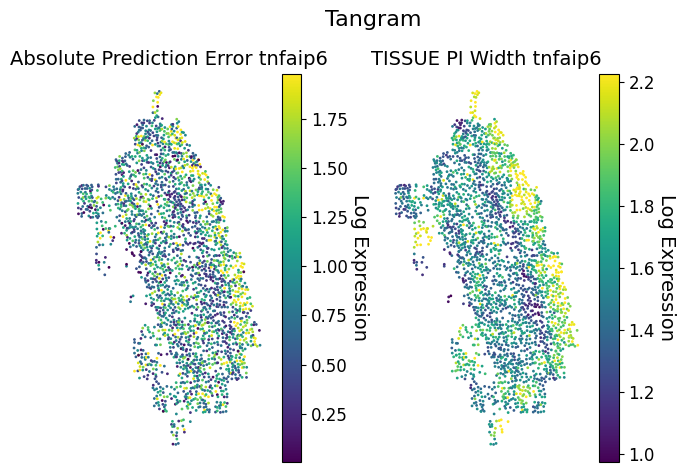

In [6]:
# tangram -- tnfaip6 - Dataset9
adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/Dataset9_knn_spage_tangram_SCPI.h5ad")
best_gene = "tnfaip6"
m = 'tangram'
pi_width = 67


################
i = np.where(adata.var_names == best_gene)[0]

# define consistent color map
all_vals = np.concatenate((np.abs(adata.X[:,i].flatten()-adata.obsm[m+"_predicted_expression"][best_gene].values),
                           adata.obsm[m+f"_predicted_expression_hi_{pi_width}"][best_gene].values-adata.obsm[m+f"_predicted_expression_lo_{pi_width}"][best_gene].values))
all_vals[all_vals<0]=0
vmin = np.percentile(np.log1p(all_vals), 0)
vmax = np.percentile(np.log1p(all_vals), 95)


fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot prediction error
ax1.axis('off')
cmap = np.abs(adata.X[:,i].flatten()-adata.obsm[m+"_predicted_expression"][best_gene].values)
cmap[cmap<0] = 0
cmap = np.log1p(cmap)
cmap[cmap > np.percentile(cmap,95)] = np.percentile(cmap,95)
im = ax1.scatter(adata.obsm['spatial'][:,0],adata.obsm['spatial'][:,1],s=1,c=cmap,rasterized=True)#,vmin=vmin,vmax=vmax)
ax1.set_title('Absolute Prediction Error ' + best_gene, fontsize = 14)
ax1.set_ylabel(best_gene)

cbar = fig.colorbar(im)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Log Expression', rotation=270, fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Plot prediction intervals
ax2.axis('off')
cmap = adata.obsm[m+f"_predicted_expression_hi_{pi_width}"][best_gene].values-adata.obsm[m+f"_predicted_expression_lo_{pi_width}"][best_gene].values
cmap[cmap<0] = 0
cmap = np.log1p(cmap)
cmap[cmap > np.percentile(cmap,95)] = np.percentile(cmap,95)
im = ax2.scatter(adata.obsm['spatial'][:,0],adata.obsm['spatial'][:,1],s=1,c=cmap,rasterized=True)#,vmin=vmin,vmax=vmax)
ax2.set_title('TISSUE PI Width ' + best_gene, fontsize = 14)

cbar = fig.colorbar(im)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Log Expression', rotation=270, fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Annotate plot
plt.suptitle(method_mapper[m], fontsize=16)
plt.tight_layout()
plt.savefig('plots/scpi_image_bounds/'+'REVISED_Dataset9_'+m+'_'+best_gene+f'_{pi_width}ci_ERROR_vs_PIwidth.pdf', dpi=500)
plt.show()

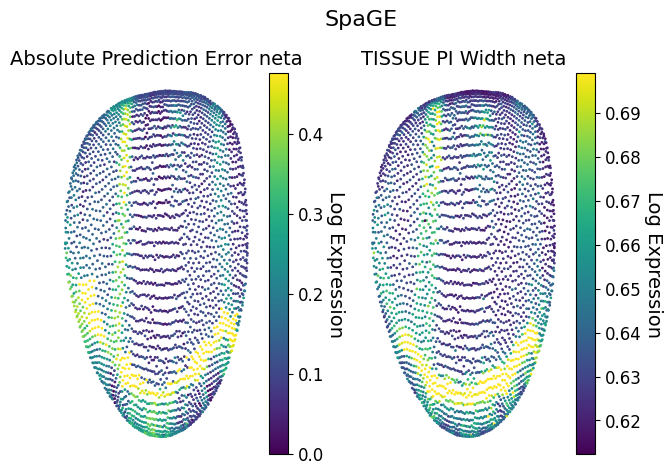

In [7]:
# spage -- neta -- Dataset 14
adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/Dataset14_knn_spage_tangram_SCPI.h5ad")
best_gene = "neta"
m = 'spage'
pi_width = 67


adata.obsm["spatial"] = adata.obsm["spatial"][:,np.array([0,2])]


################
i = np.where(adata.var_names == best_gene)[0]

# define consistent color map
all_vals = np.concatenate((np.abs(adata.X[:,i].flatten()-adata.obsm[m+"_predicted_expression"][best_gene].values),
                           adata.obsm[m+f"_predicted_expression_hi_{pi_width}"][best_gene].values-adata.obsm[m+f"_predicted_expression_lo_{pi_width}"][best_gene].values))
all_vals[all_vals<0]=0
vmin = np.percentile(np.log1p(all_vals), 0)
vmax = np.percentile(np.log1p(all_vals), 95)


fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot prediction error
ax1.axis('off')
cmap = np.abs(adata.X[:,i].flatten()-adata.obsm[m+"_predicted_expression"][best_gene].values)
cmap[cmap<0] = 0
cmap = np.log1p(cmap)
cmap[cmap > np.percentile(cmap,95)] = np.percentile(cmap,95)
im = ax1.scatter(adata.obsm['spatial'][:,0],adata.obsm['spatial'][:,1],s=1,c=cmap,rasterized=True)#,vmin=vmin,vmax=vmax)
ax1.set_title('Absolute Prediction Error ' + best_gene, fontsize = 14)
ax1.set_ylabel(best_gene)

cbar = fig.colorbar(im)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Log Expression', rotation=270, fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Plot prediction intervals
ax2.axis('off')
cmap = adata.obsm[m+f"_predicted_expression_hi_{pi_width}"][best_gene].values-adata.obsm[m+f"_predicted_expression_lo_{pi_width}"][best_gene].values
cmap[cmap<0] = 0
cmap = np.log1p(cmap)
cmap[cmap > np.percentile(cmap,95)] = np.percentile(cmap,95)
im = ax2.scatter(adata.obsm['spatial'][:,0],adata.obsm['spatial'][:,1],s=1,c=cmap,rasterized=True)#,vmin=vmin,vmax=vmax)
ax2.set_title('TISSUE PI Width ' + best_gene, fontsize = 14)

cbar = fig.colorbar(im)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Log Expression', rotation=270, fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Annotate plot
plt.suptitle(method_mapper[m], fontsize=16)
plt.tight_layout()
plt.savefig('plots/scpi_image_bounds/'+'REVISED_Dataset14_'+m+'_'+best_gene+f'_{pi_width}ci_ERROR_vs_PIwidth.pdf', dpi=500)
plt.show()

## Prediction interval width and prediction error correlation

Makes 2D heatmap plots of the TISSUE prediction interval width and the observed prediction error

In [6]:
# CELL x GENE level

pi_width = 67

methods = ['knn', 'spage', 'tangram']

datasets = ["Dataset3", "Dataset9", "Dataset11", "Dataset12", "Dataset13", "Dataset14", "Dataset15", "Dataset17", "Dataset1", "Dataset7", "Axolotl"]

# set up arrays to collect stats
all_uppers = np.array([])
all_lowers = np.array([])
all_predicteds = np.array([])
all_maes = np.array([])
all_datasets = np.array([])
all_models = np.array([])

# loop datasets
for d in datasets:
    
    # load results
    if os.path.isfile("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad"):
        adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad")
    else:
        adata = large_load("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI")
    
    if adata.shape[0] > 1000: # sample down to 1000 cells if too large
        np.random.seed(444)
        adata = adata[np.random.choice(adata.obs_names,1000,replace=False),:].copy()
    if adata.shape[1] > 300: # sample down to 300 genes if too large
        np.random.seed(444)
        adata = adata[:,np.random.choice(adata.var_names,300,replace=False)].copy()
    
    # compute stacked bandwidth matrices and stacked prediction matrices
    stacked_uppers = []
    stacked_lowers = []
    stacked_predicteds = []
    stacked_maes = []
    stacked_datasets = []
    stacked_models = []
    
    # get genes
    genes = adata.var_names
    
    # loop methods and compute all stats
    for i, method in enumerate(methods):
        stacked_uppers.append(adata.obsm[method+f"_predicted_expression_hi_{pi_width}"][genes].values)
        stacked_lowers.append(adata.obsm[method+f"_predicted_expression_lo_{pi_width}"][genes].values)
        stacked_predicteds.append(adata.obsm[method+"_predicted_expression"][genes].values)
        stacked_maes.append(np.abs(adata.obsm[method+"_predicted_expression"][genes].values-adata[:,genes].X))
        stacked_datasets.append(np.full(adata.obsm[method+"_predicted_expression"][genes].shape, d))
        stacked_models.append(np.full(adata.obsm[method+"_predicted_expression"][genes].shape, method))
    
    # append flattened versions
    all_uppers = np.concatenate([all_uppers]+[x.flatten() for x in stacked_uppers])
    all_lowers = np.concatenate([all_lowers]+[x.flatten() for x in stacked_lowers])
    all_predicteds = np.concatenate([all_predicteds]+[x.flatten() for x in stacked_predicteds])
    all_maes = np.concatenate([all_maes]+[x.flatten() for x in stacked_maes])
    all_datasets = np.concatenate([all_datasets]+[x.flatten() for x in stacked_datasets])
    all_models = np.concatenate([all_models]+[x.flatten() for x in stacked_models])

0.6653595223625491
0.677896802236968


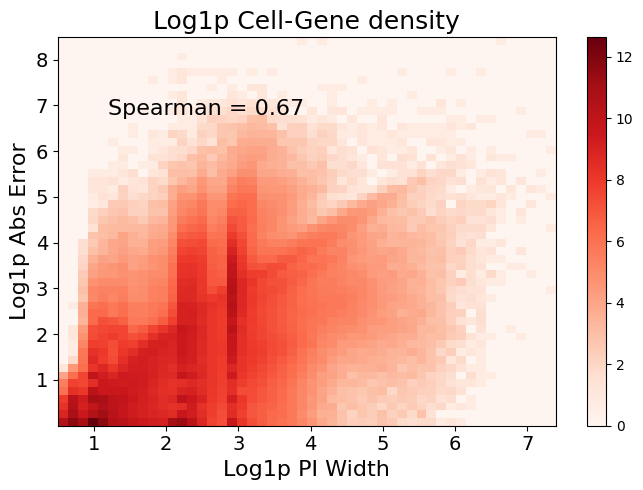

In [7]:
# compute correlations
rho, p = spearmanr(np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)])
r, p = pearsonr(np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)])
print(rho)
print(r)

# make 2D heatmap plot
plt.figure(figsize=(7,5))
heatmap, xedges, yedges = np.histogram2d(
    np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(np.log1p(heatmap).T, extent=extent, origin='lower', cmap='Reds', aspect='auto')
plt.annotate("Spearman = "+str(round(rho,2)), (0.1,0.8), xycoords="axes fraction", fontsize=16)
plt.colorbar()
plt.title("Log1p Cell-Gene density",fontsize=18)
plt.xlabel("Log1p PI Width", fontsize=16)
plt.ylabel("Log1p Abs Error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('plots/scpi_exploratory/REVISED_all_CI_vs_AE_newest.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Normalized by absolute expression

To test whether the magnitude of predicted expression is a confound for good calibration, we made a plot by dividing the prediction interval and error by the absolute magnitude of predicted expression to "normalize" out the level of expression as a confound for calibration.

In [8]:
# CELL x GENE level

pi_width = 67

methods = ['knn', 'spage', 'tangram']

datasets = ["Dataset3", "Dataset9", "Dataset11", "Dataset12", "Dataset13", "Dataset14", "Dataset15", "Dataset17", "Dataset1", "Dataset7", "Axolotl"]

# set up arrays to collect stats
all_uppers = np.array([])
all_lowers = np.array([])
all_predicteds = np.array([])
all_maes = np.array([])
all_datasets = np.array([])
all_models = np.array([])

# loop datasets
for d in datasets:
    
    # load results
    if os.path.isfile("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad"):
        adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad")
    else:
        adata = large_load("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI")
    
    if adata.shape[0] > 1000: # sample down to 1000 cells if too large
        np.random.seed(444)
        adata = adata[np.random.choice(adata.obs_names,1000,replace=False),:].copy()
    if adata.shape[1] > 300: # sample down to 300 genes if too large
        np.random.seed(444)
        adata = adata[:,np.random.choice(adata.var_names,300,replace=False)].copy()
    
    # compute stacked bandwidth matrices and stacked prediction matrices
    stacked_uppers = []
    stacked_lowers = []
    stacked_predicteds = []
    stacked_maes = []
    stacked_datasets = []
    stacked_models = []
    
    genes = adata.var_names
    
    # loop methods and get stats
    for i, method in enumerate(methods):
        stacked_uppers.append(adata.obsm[method+f"_predicted_expression_hi_{pi_width}"][genes].values/np.abs(adata.obsm[method+f"_predicted_expression"][genes].values))
        stacked_lowers.append(adata.obsm[method+f"_predicted_expression_lo_{pi_width}"][genes].values/np.abs(adata.obsm[method+f"_predicted_expression"][genes].values))
        stacked_predicteds.append(adata.obsm[method+"_predicted_expression"][genes].values)
        stacked_maes.append(np.abs(adata.obsm[method+"_predicted_expression"][genes].values-adata[:,genes].X)/np.abs(adata.obsm[method+f"_predicted_expression"][genes].values))
        stacked_datasets.append(np.full(adata.obsm[method+"_predicted_expression"][genes].shape, d))
        stacked_models.append(np.full(adata.obsm[method+"_predicted_expression"][genes].shape, method))
    
    # append flattened versions
    all_uppers = np.concatenate([all_uppers]+[x.flatten() for x in stacked_uppers])
    all_lowers = np.concatenate([all_lowers]+[x.flatten() for x in stacked_lowers])
    all_predicteds = np.concatenate([all_predicteds]+[x.flatten() for x in stacked_predicteds])
    all_maes = np.concatenate([all_maes]+[x.flatten() for x in stacked_maes])
    all_datasets = np.concatenate([all_datasets]+[x.flatten() for x in stacked_datasets])
    all_models = np.concatenate([all_models]+[x.flatten() for x in stacked_models])

/tmp/ipykernel_23682/1013986041.py:45: RuntimeWarning: divide by zero encountered in true_divide
  stacked_uppers.append(adata.obsm[method+f"_predicted_expression_hi_{pi_width}"][genes].values/np.abs(adata.obsm[method+f"_predicted_expression"][genes].values))
/tmp/ipykernel_23682/1013986041.py:46: RuntimeWarning: divide by zero encountered in true_divide
  stacked_lowers.append(adata.obsm[method+f"_predicted_expression_lo_{pi_width}"][genes].values/np.abs(adata.obsm[method+f"_predicted_expression"][genes].values))
/tmp/ipykernel_23682/1013986041.py:48: RuntimeWarning: divide by zero encountered in true_divide
  stacked_maes.append(np.abs(adata.obsm[method+"_predicted_expression"][genes].values-adata[:,genes].X)/np.abs(adata.obsm[method+f"_predicted_expression"][genes].values))
/tmp/ipykernel_23682/1013986041.py:48: RuntimeWarning: invalid value encountered in true_divide
  stacked_maes.append(np.abs(adata.obsm[method+"_predicted_expression"][genes].values-adata[:,genes].X)/np.abs(adata

/tmp/ipykernel_23682/1013986041.py:45: RuntimeWarning: divide by zero encountered in true_divide
  stacked_uppers.append(adata.obsm[method+f"_predicted_expression_hi_{pi_width}"][genes].values/np.abs(adata.obsm[method+f"_predicted_expression"][genes].values))
/tmp/ipykernel_23682/1013986041.py:46: RuntimeWarning: divide by zero encountered in true_divide
  stacked_lowers.append(adata.obsm[method+f"_predicted_expression_lo_{pi_width}"][genes].values/np.abs(adata.obsm[method+f"_predicted_expression"][genes].values))
/tmp/ipykernel_23682/1013986041.py:48: RuntimeWarning: divide by zero encountered in true_divide
  stacked_maes.append(np.abs(adata.obsm[method+"_predicted_expression"][genes].values-adata[:,genes].X)/np.abs(adata.obsm[method+f"_predicted_expression"][genes].values))
/tmp/ipykernel_23682/1013986041.py:48: RuntimeWarning: invalid value encountered in true_divide
  stacked_maes.append(np.abs(adata.obsm[method+"_predicted_expression"][genes].values-adata[:,genes].X)/np.abs(adata

0.5501850497326324
0.5828538482705752


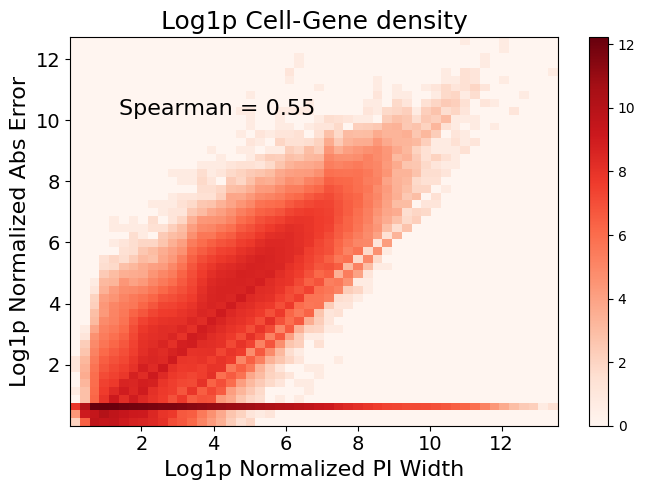

In [9]:
# compute correlations
rho, p = spearmanr(np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)])
r, p = pearsonr(np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)])
print(rho)
print(r)

# make 2D heatmap plot
plt.figure(figsize=(7,5))
heatmap, xedges, yedges = np.histogram2d(
    np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(np.log1p(heatmap).T, extent=extent, origin='lower', cmap='Reds', aspect='auto')
plt.annotate("Spearman = "+str(round(rho,2)), (0.1,0.8), xycoords="axes fraction", fontsize=16)
plt.colorbar()
plt.title("Log1p Cell-Gene density",fontsize=18)
plt.xlabel("Log1p Normalized PI Width", fontsize=16)
plt.ylabel("Log1p Normalized Abs Error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('plots/scpi_exploratory/REVISED_all_CI_vs_AE_newest_normalized.pdf', dpi=300, bbox_inches='tight')
plt.show()

### 50% Prediction Interval Width

Using 50% alpha level instead of the standard 67%

In [3]:
# CELL x GENE level

pi_width = 50

methods = ['knn', 'spage', 'tangram']

datasets = ["Dataset3", "Dataset9", "Dataset11", "Dataset12", "Dataset13", "Dataset14", "Dataset15", "Dataset17", "Dataset1", "Dataset7", "Axolotl"]

# set up arrays to collect stats
all_uppers = np.array([])
all_lowers = np.array([])
all_predicteds = np.array([])
all_maes = np.array([])
all_datasets = np.array([])
all_models = np.array([])

# loop datasets
for d in datasets:
    
    # load results
    if os.path.isfile("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad"):
        adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad")
    else:
        adata = large_load("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI")
    
    if adata.shape[0] > 1000: # sample down to 1000 cells if too large
        np.random.seed(444)
        adata = adata[np.random.choice(adata.obs_names,1000,replace=False),:].copy()
    if adata.shape[1] > 300: # sample down to 300 genes if too large
        np.random.seed(444)
        adata = adata[:,np.random.choice(adata.var_names,300,replace=False)].copy()
    
    # compute stacked bandwidth matrices and stacked prediction matrices
    stacked_uppers = []
    stacked_lowers = []
    stacked_predicteds = []
    stacked_maes = []
    stacked_datasets = []
    stacked_models = []
    
    genes = adata.var_names
    
    # loop methods and get stats
    for i, method in enumerate(methods):
        stacked_uppers.append(adata.obsm[method+f"_predicted_expression_hi_{pi_width}"][genes].values)
        stacked_lowers.append(adata.obsm[method+f"_predicted_expression_lo_{pi_width}"][genes].values)
        stacked_predicteds.append(adata.obsm[method+"_predicted_expression"][genes].values)
        stacked_maes.append(np.abs(adata.obsm[method+"_predicted_expression"][genes].values-adata[:,genes].X))
        stacked_datasets.append(np.full(adata.obsm[method+"_predicted_expression"][genes].shape, d))
        stacked_models.append(np.full(adata.obsm[method+"_predicted_expression"][genes].shape, method))
    
    # append flattened versions
    all_uppers = np.concatenate([all_uppers]+[x.flatten() for x in stacked_uppers])
    all_lowers = np.concatenate([all_lowers]+[x.flatten() for x in stacked_lowers])
    all_predicteds = np.concatenate([all_predicteds]+[x.flatten() for x in stacked_predicteds])
    all_maes = np.concatenate([all_maes]+[x.flatten() for x in stacked_maes])
    all_datasets = np.concatenate([all_datasets]+[x.flatten() for x in stacked_datasets])
    all_models = np.concatenate([all_models]+[x.flatten() for x in stacked_models])

0.6859879354277213
0.6944988821293527


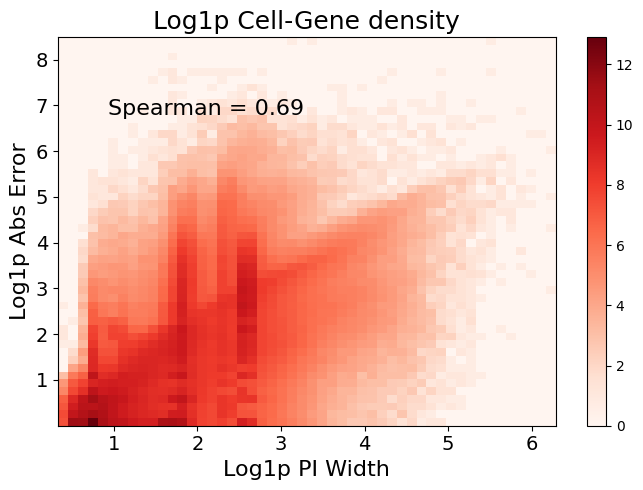

In [4]:
# compute correlations
rho, p = spearmanr(np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)])
r, p = pearsonr(np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)])
print(rho)
print(r)

# make 2D heatmap plot
plt.figure(figsize=(7,5))
heatmap, xedges, yedges = np.histogram2d(
    np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(np.log1p(heatmap).T, extent=extent, origin='lower', cmap='Reds', aspect='auto')
plt.annotate("Spearman = "+str(round(rho,2)), (0.1,0.8), xycoords="axes fraction", fontsize=16)
plt.colorbar()
plt.title("Log1p Cell-Gene density",fontsize=18)
plt.xlabel("Log1p PI Width", fontsize=16)
plt.ylabel("Log1p Abs Error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('plots/scpi_exploratory/REVISED_all_CI_vs_AE_newest_50PI.pdf', dpi=300, bbox_inches='tight')
plt.show()

### 80% Prediction Interval Width

Using 80% alpha level instead of the standard 67%

In [5]:
# CELL x GENE level

pi_width = 80

methods = ['knn', 'spage', 'tangram']

datasets = ["Dataset3", "Dataset9", "Dataset11", "Dataset12", "Dataset13", "Dataset14", "Dataset15", "Dataset17", "Dataset1", "Dataset7", "Axolotl"]


all_uppers = np.array([])
all_lowers = np.array([])
all_predicteds = np.array([])
all_maes = np.array([])
all_datasets = np.array([])
all_models = np.array([])

for d in datasets:
    
    if os.path.isfile("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad"):
        adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad")
    else:
        adata = large_load("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI")
    
    if adata.shape[0] > 1000: # sample down to 1000 cells if too large
        np.random.seed(444)
        adata = adata[np.random.choice(adata.obs_names,1000,replace=False),:].copy()
    if adata.shape[1] > 300: # sample down to 300 genes if too large
        np.random.seed(444)
        adata = adata[:,np.random.choice(adata.var_names,300,replace=False)].copy()
    
    # compute stacked bandwidth matrices and stacked prediction matrices
    stacked_uppers = []
    stacked_lowers = []
    stacked_predicteds = []
    stacked_maes = []
    stacked_datasets = []
    stacked_models = []
    
    genes = adata.var_names
    
    for i, method in enumerate(methods):
        stacked_uppers.append(adata.obsm[method+f"_predicted_expression_hi_{pi_width}"][genes].values)
        stacked_lowers.append(adata.obsm[method+f"_predicted_expression_lo_{pi_width}"][genes].values)
        stacked_predicteds.append(adata.obsm[method+"_predicted_expression"][genes].values)
        stacked_maes.append(np.abs(adata.obsm[method+"_predicted_expression"][genes].values-adata[:,genes].X))
        stacked_datasets.append(np.full(adata.obsm[method+"_predicted_expression"][genes].shape, d))
        stacked_models.append(np.full(adata.obsm[method+"_predicted_expression"][genes].shape, method))
    
    # append flattened versions
    all_uppers = np.concatenate([all_uppers]+[x.flatten() for x in stacked_uppers])
    all_lowers = np.concatenate([all_lowers]+[x.flatten() for x in stacked_lowers])
    all_predicteds = np.concatenate([all_predicteds]+[x.flatten() for x in stacked_predicteds])
    all_maes = np.concatenate([all_maes]+[x.flatten() for x in stacked_maes])
    all_datasets = np.concatenate([all_datasets]+[x.flatten() for x in stacked_datasets])
    all_models = np.concatenate([all_models]+[x.flatten() for x in stacked_models])

0.6570231779172359
0.6531637973474647


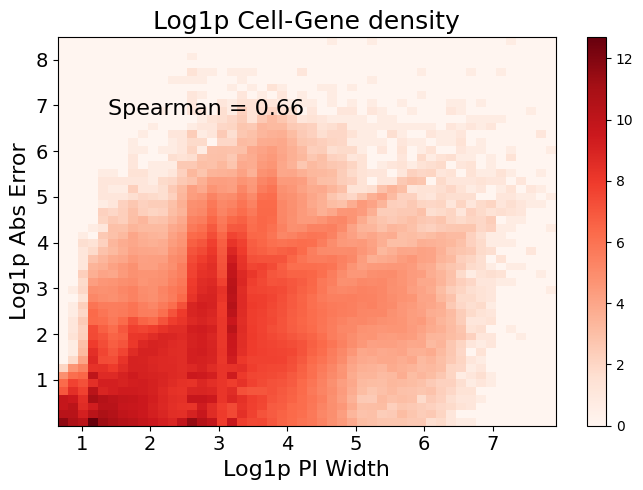

In [6]:
rho, p = spearmanr(np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)])
r, p = pearsonr(np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)])
print(rho)
print(r)

plt.figure(figsize=(7,5))
heatmap, xedges, yedges = np.histogram2d(
    np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(np.log1p(heatmap).T, extent=extent, origin='lower', cmap='Reds', aspect='auto')
plt.annotate("Spearman = "+str(round(rho,2)), (0.1,0.8), xycoords="axes fraction", fontsize=16)
plt.colorbar()
plt.title("Log1p Cell-Gene density",fontsize=18)
plt.xlabel("Log1p PI Width", fontsize=16)
plt.ylabel("Log1p Abs Error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('plots/scpi_exploratory/REVISED_all_CI_vs_AE_newest_80PI.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Upper vs Lower prediction interval distributions

Measuring distributions of the lower prediction interval expression level and the upper prediction interval expression level across datasets

In [7]:
pi_width = 67 # prediction interval width

datasets = ["Dataset3", "Dataset9", "Dataset11", "Dataset12", "Dataset13", "Dataset14", "Dataset15", "Dataset17", "Dataset1", "Axolotl"] # "Dataset7"
methods = ['knn', 'spage', 'tangram']

dataset_col = []
method_col = []
value_col = []
upper_lower_col = []

# loop through each dataset
for d in datasets:
    
    # load in data
    if os.path.isfile("scg_results/scpi/2023Aug1_kautokauto_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad"):
        adata = sc.read_h5ad("scg_results/scpi/2023Aug1_kautokauto_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad")
    else:
        adata = large_load("scg_results/scpi/2023Aug1_kautokauto_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI")
    
    if adata.shape[0] > 1000: # sample down to 1000 cells if too large
        np.random.seed(444)
        adata = adata[np.random.choice(adata.obs_names,1000,replace=False),:].copy()
    if adata.shape[1] > 300: # sample down to 300 genes if too large
        np.random.seed(444)
        adata = adata[:,np.random.choice(adata.var_names,300,replace=False)].copy()
    
    # get genes
    genes = adata.var_names
    
    # loop through methods
    for method in methods:
        
        lower = adata.obsm[method+f"_predicted_expression_lo_{pi_width}"][genes].values
        upper = adata.obsm[method+f"_predicted_expression_hi_{pi_width}"][genes].values
        
        # get lower and upper intervals for each gene
        for j in range(adata.obsm[method+"_predicted_expression"].shape[1]):
            
            mean_lower = np.nanmean(lower[:,j])
            mean_upper = np.nanmean(upper[:,j])
            
            name = dataset_mapper[d]
            
            dataset_col += [name,name]
            method_col += [method_mapper[method],method_mapper[method]]
            value_col += [mean_lower, mean_upper]
            upper_lower_col += ["Lower", "Upper"]

In [8]:
# compile dataframe
df = pd.DataFrame([])
df["Dataset"] = dataset_col
df["Method"] = method_col
df["Mean Expression Level"] = value_col
df["Log1p Mean Expression"] = np.log1p(value_col)
df["Interval Bound"] = upper_lower_col

/tmp/ipykernel_23743/1303754508.py:6: RuntimeWarning: invalid value encountered in log1p
  df["Log1p Mean Expression"] = np.log1p(value_col)


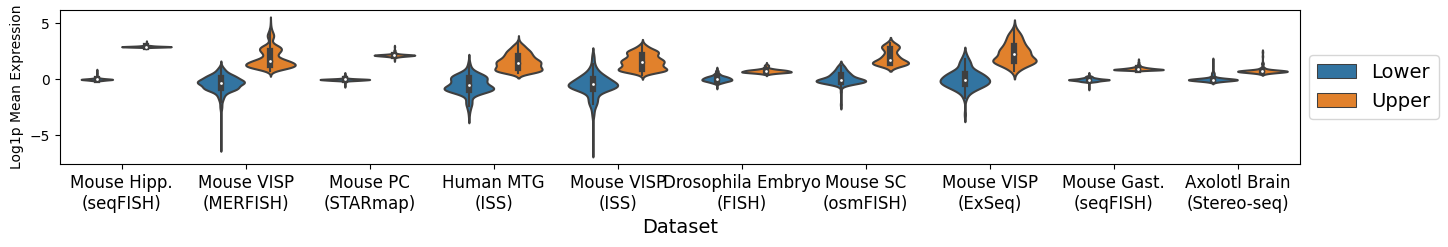

In [9]:
# make violin plots of the lower and upper prediction interval distributions
plt.figure(figsize=(16,2))
sns.violinplot(x="Dataset", y="Log1p Mean Expression", hue="Interval Bound", data=df)
plt.xlabel("Dataset", fontsize=14)
plt.ylabel("Log1p Mean Expression", fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, ncol=1)
plt.savefig('plots/scpi_exploratory/violin_lower_upper_bounds_67.pdf', dpi=300, bbox_inches='tight')
plt.show()